In [1]:
# -*- coding: utf-8 -*-
import os
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tempfile
from pathlib import Path


from qiskit import QuantumCircuit, transpile
from qiskit.exceptions import QiskitError
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.quantum_info import DensityMatrix, state_fidelity
from sklearn.linear_model import Ridge
import tensorflow_probability as tfp
tfd = tfp.distributions

# ── 乱数固定 ─────────────────────────────────────────────────────────────
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# ── IBM Runtime アカウント登録（初回のみ置換） ──────────────────────────
QiskitRuntimeService.save_account(
    channel='ibm_cloud',
    token='hUNKim03EUNPLFj0N2_D1GOZRyDVInRyGMDNptErzBCN',  # ←本番は環境変数で
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/a18f5d3ff3d6488282e0b608e5df82a1:f4255985-ae82-465b-9b64-fa2ef36a9e2c::',
    overwrite=True,
    set_as_default=True
)



# ── サービス & 実機ノイズモデル由来バックエンド ──────────────────────────
service      = QiskitRuntimeService()
real_backend = service.backend('ibm_brisbane')
base_noise_model = NoiseModel.from_backend(real_backend)
noise_model = base_noise_model

measurement_backend_dm   = AerSimulator(method='density_matrix', noise_model=noise_model)  # 忠実度参照
measurement_backend_sv   = AerSimulator(method='statevector')                               # ナビ用（擬似IQ）
measurement_backend_qasm = AerSimulator(method='automatic',    noise_model=noise_model)     # 可視化でcounts用

from qiskit.circuit import Parameter

# ← measurement_backend_dm, measurement_backend_sv を作ったすぐ後あたり
#    （ノイズ付き fidelity を出す側のテンプレ）
th, ph = Parameter('th'), Parameter('ph')
qc_tpl_dm = QuantumCircuit(1)
qc_tpl_dm.ry(th, 0); qc_tpl_dm.rx(ph, 0)
qc_tpl_dm.save_density_matrix()  # 忠実度評価用
tqc_dm = transpile(qc_tpl_dm, measurement_backend_dm, optimization_level=0)

# （任意）CPU並列を効かせる
measurement_backend_dm.set_options(
    max_parallel_threads=os.cpu_count(),
    max_parallel_experiments=8
)

# --- 書き込み可能なキャッシュディレクトリを用意 ---
DATA_DIR = Path(os.environ.get("NGRC_DATA_DIR", Path(tempfile.gettempdir()) / "ngrc_cache"))
DATA_DIR.mkdir(parents=True, exist_ok=True)
print(f"[NG-RC] cache dir = {DATA_DIR}")

# ── ユーティリティ ────────────────────────────────────────────────────
def get_IQ_timeseries(qc_eval, backend_sv, steps: int = 60):
    # --- 角度総和の抽出（新API）---
    theta_total, phi_total = 0.0, 0.0
    for inst in qc_eval.data:
        op = inst.operation
        if op.name == 'ry':
            theta_total += float(op.params[0])
        elif op.name == 'rx':
            phi_total   += float(op.params[0])

    # --- 時分割（Ry前半 / Rx後半）---
    qc_ts = QuantumCircuit(1)
    th_step = theta_total / steps
    ph_step = phi_total   / steps
    labels = []

    # Ry区間
    for s in range(steps // 2):
        qc_ts.ry(th_step * 2.0, 0)  # 合計でtheta_totalになるよう2倍×(steps//2)
        lab = f"sv_ry_{s}"
        qc_ts.save_statevector(label=lab)
        labels.append(lab)

    # 端数
    residual_theta = theta_total - th_step * 2.0 * (steps // 2)
    if abs(residual_theta) > 1e-12:
        qc_ts.ry(residual_theta, 0); lab = "sv_ry_res"
        qc_ts.save_statevector(label=lab); labels.append(lab)

    # Rx区間
    for s in range(steps // 2):
        qc_ts.rx(ph_step * 2.0, 0)
        lab = f"sv_rx_{s}"
        qc_ts.save_statevector(label=lab)
        labels.append(lab)

    residual_phi = phi_total - ph_step * 2.0 * (steps // 2)
    if abs(residual_phi) > 1e-12:
        qc_ts.rx(residual_phi, 0); lab = "sv_rx_res"
        qc_ts.save_statevector(label=lab); labels.append(lab)

    # 実行
    tqc = transpile(qc_ts, backend_sv, optimization_level=0)
    res = backend_sv.run(tqc).result()

    # --- Bloch期待値（X, Y）→ I(t), Q(t) ---
    I_list, Q_list = [], []
    for lab in labels:
        psi = np.asarray(res.data(0)[lab], dtype=complex)
        a, b = psi[0], psi[1]
        rx = 2*np.real(np.conj(a)*b)            # ⟨X⟩
        ry = 2*np.imag(np.conj(a)*b)            # ⟨Y⟩ ←ここが重要（符号修正）
        I_list.append(rx); Q_list.append(ry)

    return np.asarray(I_list, float), np.asarray(Q_list, float)


def get_density_matrix(qc, backend):
    qc2 = qc.copy(); qc2.save_density_matrix()
    tqc = transpile(qc2, backend)
    result = backend.run(tqc).result()
    return np.asarray(result.data(0)['density_matrix'])

def get_counts(qc, backend, shots=8192):
    qc2 = qc.copy(); qc2.measure_all()
    tqc = transpile(qc2, backend)
    result = backend.run(tqc, shots=shots).result()
    return result.get_counts(0)

def compute_fidelity_to_Rx_pi2(density_matrix_measured):
    # Rx(pi/2)|0> = (1/√2) [1, -i]
    psi_ideal = (1/np.sqrt(2)) * np.array([1, -1j])
    rho_ideal = DensityMatrix(psi_ideal)
    rho_measured = DensityMatrix(density_matrix_measured)
    return state_fidelity(rho_ideal, rho_measured)

def analyze_waveform_frequency(I_waveform, Q_waveform, dt_ns=0.5):
    dt_sec = dt_ns * 1e-9
    I_fft = np.fft.fft(I_waveform)
    Q_fft = np.fft.fft(Q_waveform)
    freqs_hz = np.fft.fftfreq(len(I_waveform), d=dt_sec)
    return freqs_hz/1e9, np.abs(I_fft), np.abs(Q_fft)  # GHz

def compute_angles_from_IQ(I_waveform, Q_waveform, dt=0.5):
    Omega_t = np.sqrt(I_waveform**2 + Q_waveform**2)  # 瞬時ラビ周波数
    theta = np.sum(Omega_t) * dt
    theta = np.mod(theta, 2*np.pi)
    phi = np.arctan2(np.sum(Q_waveform), np.sum(I_waveform))
    return theta, phi

def eval_noisy_fidelities(theta_list, phi_list):
    """θ,φ の配列をまとめてノイズ付きで実行→忠実度リストを返す"""
    # 1. パラメータをバインドして一括実行
    bound = [tqc_dm.assign_parameters({th: float(t), ph: float(p)}, inplace=False)
         for t, p in zip(theta_list, phi_list)]
    
    result = measurement_backend_dm.run(bound).result()

    # 2. density_matrix → fidelity
    F_list = []
    for i in range(len(bound)):
        rho = np.asarray(result.data(i)['density_matrix'])
        F_list.append(compute_fidelity_to_Rx_pi2(rho))
    return F_list

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

class NGReservoirComputer:
    """
    NG-RC：時間列 IQ(t) → 非重複窓平均 → 低次数モノミアル → Ridge
      w         : 非重複の時間窓幅（サンプル数で指定）
      use_deg3  : 三次モノミアルを使うか（False でもOK）
      alpha     : Ridge 正則化
    """
    def __init__(self, w: int = 10, use_deg3: bool = True, alpha: float = 1.0):
        self.w = w
        self.use_deg3 = use_deg3
        self.scaler = StandardScaler()
        self.model = Ridge(alpha=alpha)

    @staticmethod
    def _window_means_ts(x: np.ndarray, w: int) -> np.ndarray:
        T = (len(x) // w)
        if T <= 0:
            return np.array([], float)
        return np.array([float(np.mean(x[t*w:(t+1)*w])) for t in range(T)], float)

    @staticmethod
    def _mono_linear(Iw, Qw):
        return np.column_stack([Iw, Qw]).reshape(-1)

    @staticmethod
    def _mono_quadratic(Iw, Qw):
        return np.column_stack([Iw*Iw, Qw*Qw, Iw*Qw]).reshape(-1)

    @staticmethod
    def _mono_cubic(Iw, Qw):
        I3  = Iw*Iw*Iw
        Q3  = Qw*Qw*Qw
        I2Q = (Iw*Iw)*Qw
        IQ2 = Iw*(Qw*Qw)
        return np.column_stack([I3, Q3, I2Q, IQ2]).reshape(-1)

    def features(self, I_t: np.ndarray, Q_t: np.ndarray) -> np.ndarray:
        Iw = self._window_means_ts(I_t, self.w)
        Qw = self._window_means_ts(Q_t, self.w)
        feats = [self._mono_linear(Iw, Qw), self._mono_quadratic(Iw, Qw)]
        if self.use_deg3:
            feats.append(self._mono_cubic(Iw, Qw))
        return np.concatenate(feats) if feats else np.array([], float)

    def fit(self, df: pd.DataFrame) -> None:
        # df: {'I_t': ndarray(T,), 'Q_t': ndarray(T,), 'label': float}
        X = np.stack([self.features(r['I_t'], r['Q_t']) for _, r in df.iterrows()])
        y = df['label'].values.astype(float)
        Xs = self.scaler.fit_transform(X)
        self.model.fit(Xs, y)

    def predict(self, I_t: np.ndarray, Q_t: np.ndarray) -> float:
        f = self.features(I_t, Q_t).reshape(1, -1)
        fs = self.scaler.transform(f)
        return float(np.clip(self.model.predict(fs)[0], 0.0, 1.0))


# ── ナビ用データの生成／学習 ─────────────────────────────────────────────
def make_nav_dataset(backend_sv, backend_dm, n_each=200, steps=60, w=10):
    """
    時間列 IQ(t) を使う論文準拠データセット。
    - backend_sv: statevector（IQ(t) 生成用）
    - backend_dm: density_matrix + noise（ラベル用）
    """
    def base_states():
        yield lambda qc: None
        yield lambda qc: qc.x(0)
        yield lambda qc: qc.rx(np.pi/2, 0)
        yield lambda qc: qc.rx(-np.pi/2, 0)
        yield lambda qc: qc.ry(np.pi/2, 0)
        yield lambda qc: qc.ry(-np.pi/2, 0)
        yield lambda qc: qc.rx(np.pi/4, 0)
        yield lambda qc: qc.ry(np.pi/4, 0)
        yield lambda qc: qc.rx(3*np.pi/4, 0)
        yield lambda qc: qc.ry(3*np.pi/4, 0)

    rows = []
    for prep in base_states():
        for _ in range(n_each):
            # 評価用の角度（乱れを付与）
            delta = np.random.uniform(-0.02, 0.02)
            qc_eval = QuantumCircuit(1)
            prep(qc_eval)
            qc_eval.rz(delta, 0)

            # --- 時間列 IQ(t) を取得（SVベース疑似） ---
            I_t, Q_t = get_IQ_timeseries(qc_eval, backend_sv, steps=steps)

            # --- ラベル（ノイズありの忠実度） ---
            qc_dm = qc_eval.copy()
            qc_dm.save_density_matrix()
            rho = np.asarray(backend_dm.run(transpile(qc_dm, backend_dm)).result().data(0)['density_matrix'])
            F = compute_fidelity_to_Rx_pi2(rho)  # 既存の関数を再利用

            rows.append({'I_t': I_t.astype(float), 'Q_t': Q_t.astype(float), 'label': float(F)})

    return pd.DataFrame(rows)


# --- 論文準拠: 時間列IQデータの生成 or 読込（この直後に入れる） ---
# --- 時間列IQデータの生成 or 読込 ---
NAV_TS_PATH = DATA_DIR / "NAV_dataset_timeseries.pkl"
if not NAV_TS_PATH.exists():
    print('[NG-RC] NAV_dataset_timeseries.pkl が無いので生成 …')
    nav_ts_df = make_nav_dataset(   # ← あなたの定義名に合わせてOK
        backend_sv = measurement_backend_sv,   # IQ(t) 生成（疑似）
        backend_dm = measurement_backend_dm,   # 忠実度ラベル（ノイズあり）
        n_each = 200, steps = 60, w = 10
    )
    nav_ts_df.to_pickle(NAV_TS_PATH)
else:
    print(f"[NG-RC] load cache ← {NAV_TS_PATH}")
    nav_ts_df = pd.read_pickle(NAV_TS_PATH)

# --- w と α の簡易CV（timeseries列名で統一） ---
from sklearn.model_selection import train_test_split
import numpy as np

train_df, val_df = train_test_split(nav_ts_df, test_size=0.2, random_state=42)
best, best_cfg = 1e9, None
for w in [6, 8, 10, 12, 15]:
    for a in [0.1, 1.0, 3.0, 10.0]:
        m = NGReservoirComputer(w=w, use_deg3=True, alpha=a)  # ← 新版の引数
        m.fit(train_df)                                       # df: I_t,Q_t,label
        preds = [m.predict(r['I_t'], r['Q_t']) for _, r in val_df.iterrows()]
        mae = float(np.mean(np.abs(np.array(preds) - val_df['label'].values)))
        if mae < best: best, best_cfg = mae, (w, a)

print(f"[NAV/TS] best w={best_cfg[0]}, alpha={best_cfg[1]} (val MAE={best:.4f})")

# ベストで全データ学習
best_w, best_alpha = best_cfg
ng_rc = NGReservoirComputer(w=best_w, use_deg3=True, alpha=best_alpha)
ng_rc.fit(nav_ts_df)
print('[NG-RC] ナビ学習完了 (label=fidelity_to_Rx(pi/2), features=windowed monomials)')




# ── RL エージェント ────────────────────────────────────────────────────
class MultiObjectivePolicyGradientAgent:
    def __init__(self, state_size, min_waveform_length=45, max_waveform_length=70, initial_learning_rate=0.001):
        self.state_size = state_size
        self.min_waveform_length = min_waveform_length
        self.max_waveform_length = max_waveform_length
        self.waveform_length_range = self.max_waveform_length - self.min_waveform_length + 1
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
        self.best_waveform = None
        self.best_reward = -float('inf')
        self.model = self._build_model()

    def _build_model(self):
        initializer = tf.keras.initializers.GlorotUniform()
        model_input = tf.keras.layers.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer)(model_input)
        x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
        x = tf.keras.layers.Reshape((256, 1))(x)
        x = tf.keras.layers.LSTM(128, return_sequences=False)(x)

        waveform_param_size = 4 * self.max_waveform_length
        waveform_params = tf.keras.layers.Dense(waveform_param_size, activation='tanh', kernel_initializer=initializer)(x)
        waveform_length_logits_size = self.waveform_length_range
        waveform_length_logits = tf.keras.layers.Dense(waveform_length_logits_size, activation=None,
                                                       kernel_initializer=initializer, bias_initializer='zeros')(x)
        return tf.keras.Model(inputs=model_input, outputs=[waveform_params, waveform_length_logits])

    def generate_waveform(self, state):
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
        waveform_params, waveform_length_logits = self.model(state_tensor)
        waveform_params = waveform_params[0]; waveform_length_logits = waveform_length_logits[0]

        max_amplitude = 0.13
        L_dist = tfd.Categorical(logits=waveform_length_logits)
        L_idx  = L_dist.sample()
        L      = self.min_waveform_length + L_idx
        L      = tf.cast(L, tf.int32)
        L_val  = int(L.numpy())

        I_mean = max_amplitude * waveform_params[:self.max_waveform_length]
        I_std  = max_amplitude * (tf.nn.softplus(waveform_params[self.max_waveform_length:2*self.max_waveform_length]) + 1e-3)
        Q_mean = max_amplitude * waveform_params[2*self.max_waveform_length:3*self.max_waveform_length]
        Q_std  = max_amplitude * (tf.nn.softplus(waveform_params[3*self.max_waveform_length:4*self.max_waveform_length]) + 1e-3)

        I_full = tf.clip_by_value(I_mean + I_std*tf.random.normal(I_mean.shape), -max_amplitude, max_amplitude)
        Q_full = tf.clip_by_value(Q_mean + Q_std*tf.random.normal(Q_mean.shape), -max_amplitude, max_amplitude)
        I = I_full[:L_val]; Q = Q_full[:L_val]
        return I.numpy(), Q.numpy(), L_val

    def compute_discounted_rewards(self, rewards, gamma=0.98):
        discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
        cumulative = 0.0
        for t in reversed(range(len(rewards))):
            cumulative = rewards[t] + gamma * cumulative
            discounted_rewards[t] = cumulative
        return discounted_rewards

    def update_policy(self, states, rewards, actions, gamma=0.98):
        discounted = self.compute_discounted_rewards(rewards, gamma).astype(np.float32)
        if len(discounted) > 1:
            discounted = (discounted - discounted.mean()) / (discounted.std() + 1e-8)
        discounted = tf.convert_to_tensor(discounted, dtype=tf.float32)

        with tf.GradientTape() as tape:
            state_tensors = tf.convert_to_tensor(states, dtype=tf.float32)
            wf_params_batch, wf_len_logits_batch = self.model(state_tensors)

            log_probs = []
            maxL = self.max_waveform_length
            for i, act in enumerate(actions):
                L_val = int(act['L'])
                I_samp = tf.convert_to_tensor(act['I'][:L_val], dtype=tf.float32)
                Q_samp = tf.convert_to_tensor(act['Q'][:L_val], dtype=tf.float32)

                params = wf_params_batch[i]
                len_logits = wf_len_logits_batch[i]
                L_dist = tfd.Categorical(logits=len_logits)
                L_idx  = tf.cast(L_val - self.min_waveform_length, tf.int32)
                logp_L = L_dist.log_prob(L_idx)

                I_mean = 0.13 * params[:maxL]
                I_std  = 0.13 * (tf.nn.softplus(params[maxL:2*maxL]) + 1e-3)
                Q_mean = 0.13 * params[2*maxL:3*maxL]
                Q_std  = 0.13 * (tf.nn.softplus(params[3*maxL:4*maxL]) + 1e-3)

                I_dist = tfd.Normal(I_mean[:L_val], I_std[:L_val])
                Q_dist = tfd.Normal(Q_mean[:L_val], Q_std[:L_val])

                logp_I = tf.reduce_sum(I_dist.log_prob(I_samp))
                logp_Q = tf.reduce_sum(Q_dist.log_prob(Q_samp))
                log_probs.append(logp_I + logp_Q + logp_L)

            log_probs = tf.stack(log_probs)
            loss = -tf.reduce_mean(discounted * log_probs)

        grads = tape.gradient(loss, self.model.trainable_variables)
        grads_and_vars = [(g, v) for g, v in zip(grads, self.model.trainable_variables) if g is not None]
        if not grads_and_vars:
            return
        grads_and_vars = [(tf.clip_by_value(g, -5.0, 5.0), v) for g, v in grads_and_vars]
        self.optimizer.apply_gradients(grads_and_vars)

# ── 最適化ループ ───────────────────────────────────────────────────────
def design_and_optimize_pulse(agent, backend_dm, backend_sv,
                              ngrc_model=None, use_nav=False,
                              cycles=2500, batch_size=32, log_rows=None):

    if use_nav and ngrc_model is None:
        raise ValueError("use_nav=True ですが ngrc_model が None です。")

    total_batches = int(math.ceil(cycles / batch_size))
    global_batch = 0

    # --- NGRC 前ふるいの設定（安価な予測で候補を絞る）---
    CAND = 8   # 1状態につき候補波形を何本出すか（NNから）
    TOPM = 2   # 上位何本だけノイズ付き忠実度 F を計算するか
    SCORE_THRESHOLD = None  # 例: 0.02 とかにするとしきい値未満を全スキップ

    # 重みは固定：α=0.90（忠実度）β=0.05（ナビ）γ=0.05（長さ）
    def weight_schedule_for_rank():
        # α_rank, β_rank, γ_rank
        return 0.90, 0.05, 0.05

    # 新規（reward 用：学習にはナビを入れない＝β_reward=0）
    def weight_schedule_for_reward():
        # α_reward, β_reward=0, γ_reward
        return 0.9, 0.0, 0.10
  

    def prescreen_candidates(state, beta, gamma):
        """
        NNが出す候補を NGRC で事前スコアリングしてふるいにかける。
        返り値: [(score, pack), ...] を score 降順にソート
        pack は (I_waveform, Q_waveform, L, theta, phi, qc_eval, hatF, len_pen) のタプル
        """
        cands = []
        for _ in range(CAND):
            # 1) NNから波形をサンプル
            Iw, Qw, L = agent.generate_waveform(state)
            theta, phi = compute_angles_from_IQ(Iw, Qw)
            qc_eval = QuantumCircuit(1); qc_eval.ry(theta, 0); qc_eval.rx(phi, 0)

            # 2) “安い”特徴（時系列IQ）→ NGRCの予測
            I_t, Q_t = get_IQ_timeseries(qc_eval, backend_sv, steps=60)
            hatF = float(np.clip(ngrc_model.predict(I_t, Q_t), 0.0, 1.0)) if (ngrc_model is not None) else 0.0

            # 3) 長さペナルティ
            len_pen = (L - agent.min_waveform_length) / (agent.max_waveform_length - agent.min_waveform_length)

            # 4) 事前スコア（安価）： s = β * ĤF − γ * len_pen
            s = beta * hatF - gamma * len_pen
            cands.append((s, (Iw, Qw, L, theta, phi, qc_eval, hatF, len_pen)))

        # スコア降順でソート
        cands.sort(key=lambda x: x[0], reverse=True)

        # しきい値を設定したい場合はここでフィルタ
        if SCORE_THRESHOLD is not None:
            cands = [c for c in cands if c[0] >= SCORE_THRESHOLD]

        return cands

    if log_rows is None:
        log_rows = []

    all_rewards = []
    batch_states, batch_rewards = [], []
    current_batch_actions = []
    action_states = []  

    fidelity_list, total_reward_list = [], []
    waveform_length_list, theta_list, phi_list = [], [], []

    for cycle in range(cycles):
        if (cycle % 10) == 0:
            print(f"Cycle {cycle + 1}/{cycles}")

        qc = QuantumCircuit(1, name='state_experiment')
        try:
            density_matrix = get_density_matrix(qc, backend_dm)
        except QiskitError as e:
            print(f"Cycle {cycle + 1}: {e}")
            continue

        state_vector = np.concatenate([np.real(density_matrix).flatten(),
                                       np.imag(density_matrix).flatten()])
        batch_states.append(state_vector)
        batch_rewards.append(0.0)

        if (cycle + 1) % batch_size == 0:
            current_batch_states = batch_states.copy()
            current_batch_rewards = []
            current_batch_actions = []

            batch_fidelity, batch_total_reward = [], []
            batch_waveform_length, batch_theta, batch_phi = [], [], []
            action_states = []  


            for state in current_batch_states:
                # 学習重み（報酬の中でも再利用）
                alpha_rank, beta_rank, gamma_rank = weight_schedule_for_rank()

                # 1) 事前ふるい：安価な NGRC 予測で候補をランキング
                if use_nav:
                    ranked = prescreen_candidates(state, beta_rank, gamma_rank)
                else:
                    # ナビ無効: 1本だけ評価（pre_score は長さペナルティ分だけ反映）
                    Iw, Qw, L = agent.generate_waveform(state)
                    theta, phi = compute_angles_from_IQ(Iw, Qw)
                    qc_eval = QuantumCircuit(1); qc_eval.ry(theta, 0); qc_eval.rx(phi, 0)
                    hatF = 0.0
                    len_pen = (L - agent.min_waveform_length) / (agent.max_waveform_length - agent.min_waveform_length)
                    pre_s = - gamma_rank * len_pen   # β=0 を仮定
                    ranked = [(pre_s, (Iw, Qw, L, theta, phi, qc_eval, hatF, len_pen))]

                # 2) 上位 TOPM 本だけノイズ側忠実度 F を計算（重い）
                # 2) 上位 TOPM 本だけノイズ側忠実度 F を"まとめて"計算
                evaluated_any = False
                top_take = ranked[:TOPM] if len(ranked) > 0 else []

                # ---- ここから置換ブロック ----
                if top_take:
                    # まず θ,φ を抜き出して一括で fidelity を計算
                    thetas = [pack[3] for _, pack in top_take]  # pack = (Iw,Qw,L,theta,phi, ...)
                    phis   = [pack[4] for _, pack in top_take]
                    F_batch = eval_noisy_fidelities(thetas, phis)

                    for (rank_idx, (pre_s, pack)), F in zip(enumerate(top_take), F_batch):
                        Iw, Qw, L, theta, phi, qc_eval, hatF, len_pen = pack
                        fidelity_used = F

                        # 報酬は“実測Fと長さ”のみ（ナビは入れない）
                        alpha_rw, beta_rw, gamma_rw = weight_schedule_for_reward()  # β_rw=0
                        total_reward = alpha_rw * fidelity_used - gamma_rw * len_pen

                        # ログ
                        log_rows.append({
                            'cycle': cycle, 'batch_id': cycle // batch_size,
                            'rank': rank_idx, 'pre_score': float(pre_s),
                            'hatF': float(hatF), 'len_pen': float(len_pen),
                            'fidelity_used': float(fidelity_used),
                            'reward': float(total_reward),
                            'wave_len': int(L),
                            'theta': float(theta), 'phi': float(phi),
                            'alpha_rank': float(alpha_rank), 'beta_rank': float(beta_rank), 'gamma_rank': float(gamma_rank),
                            'alpha_reward': float(alpha_rw), 'beta_reward': float(beta_rw), 'gamma_reward': float(gamma_rw),
                            'run_tag': 'nav' if use_nav else 'rl_only'
                        })

                        # 集計
                        all_rewards.append(total_reward)
                        current_batch_rewards.append(total_reward)
                        current_batch_actions.append({'L': int(L), 'I': Iw, 'Q': Qw})
                        action_states.append(state)
                        batch_fidelity.append(fidelity_used)
                        batch_total_reward.append(total_reward)
                        batch_waveform_length.append(L)
                        batch_theta.append(theta); batch_phi.append(phi)
                        evaluated_any = True

                        if total_reward > agent.best_reward:
                            agent.best_reward = total_reward
                            agent.best_waveform = {
                                'I_waveform': Iw, 'Q_waveform': Qw,
                                'theta': theta, 'phi': phi, 'reward': total_reward
                            }
                            print(f"    Best waveform updated with reward: {agent.best_reward:.4f}")
                # ---- 置換ブロックここまで ----
          
                # 3') しきい値で全部落ちて評価0本の救済（任意）
                if use_nav and not evaluated_any and len(ranked) > 0:
                    pre_s, pack = ranked[0]
                    Iw, Qw, L, theta, phi, qc_eval, hatF, len_pen = pack
                    F = eval_noisy_fidelities([theta], [phi])[0]
                    alpha_rw, beta_rw, gamma_rw = weight_schedule_for_reward()
                    total_reward = alpha_rw * F - gamma_rw * len_pen

                    log_rows.append({
                        'cycle': cycle, 'batch_id': cycle // batch_size,
                        'rank': 0, 'pre_score': float(pre_s),
                        'hatF': float(hatF), 'len_pen': float(len_pen),
                        'fidelity_used': float(F),
                        'reward': float(total_reward),
                        'wave_len': int(L),
                        'theta': float(theta), 'phi': float(phi),
                        # rank 用の重み
                        'alpha_rank': float(alpha_rank), 'beta_rank': float(beta_rank), 'gamma_rank': float(gamma_rank),
                        # reward 用の重み（β_reward=0）
                        'alpha_reward': float(alpha_rw), 'beta_reward': float(beta_rw), 'gamma_reward': float(gamma_rw),
                        'run_tag': 'nav' if use_nav else 'rl_only'
                    })
                    
                    all_rewards.append(total_reward)
                    current_batch_rewards.append(total_reward)
                    current_batch_actions.append({'L': int(L), 'I': Iw, 'Q': Qw})
                    action_states.append(state)  # ★ 追加


                    batch_fidelity.append(F)
                    batch_total_reward.append(total_reward)
                    batch_waveform_length.append(L)
                    batch_theta.append(theta); batch_phi.append(phi)

                    if total_reward > agent.best_reward:
                        agent.best_reward = total_reward
                        agent.best_waveform = {
                            'I_waveform': Iw, 'Q_waveform': Qw,
                            'theta': theta, 'phi': phi, 'reward': total_reward
                        }
                        print(f"    Best waveform updated with reward: {agent.best_reward:.4f}")

           
            fidelity_list.extend(batch_fidelity)
            total_reward_list.extend(batch_total_reward)
            waveform_length_list.extend(batch_waveform_length)
            theta_list.extend(batch_theta); phi_list.extend(batch_phi)



            # ★ 念のため、空バッチはスキップ
            if current_batch_actions:
                agent.update_policy(
                    states=action_states,            # ← ここが肝
                    rewards=current_batch_rewards,
                    actions=current_batch_actions
                    )

            global_batch += 1
            batch_states, batch_rewards = [], []

    return (all_rewards, fidelity_list, total_reward_list,
            waveform_length_list, theta_list, phi_list)

# ── 可視化 ──────────────────────────────────────────────────────────────
def visualize_results(agent, results, batch_size=32, topm=2):
    """
    batch_size: 学習の1バッチのサイクル数（design_and_optimize_pulseのbatch_sizeと合わせる）
    topm      : 1サイクル内で実測する候補本数（optimizer側のTOPMと合わせる）
    """
    import math
    (all_rewards, fidelity_list, total_reward_list,
     waveform_length_list, theta_list, phi_list) = results

    # 出力系列の長さ N は「1サイクルでTOPM個」足し込まれているので、
    # 可視化の集計幅は stride = batch_size * topm
    N = len(total_reward_list)
    stride = batch_size * topm
    num_batches = math.ceil(N / stride)

    mean_fidelity_list, median_fidelity_list = [], []
    mean_total_reward_list, median_total_reward_list = [], []
    mean_waveform_length_reward_list, median_waveform_length_reward_list = [], []

    for i in range(num_batches):
        start_idx = i * stride
        end_idx   = min(N, start_idx + stride)

        mean_fidelity = np.mean(fidelity_list[start_idx:end_idx])
        mean_total_reward = np.mean(total_reward_list[start_idx:end_idx])
        median_fidelity = np.median(fidelity_list[start_idx:end_idx])
        median_total_reward = np.median(total_reward_list[start_idx:end_idx])

        wl_rewards = [1 - wl / agent.max_waveform_length
                      for wl in waveform_length_list[start_idx:end_idx]]
        mean_waveform_length_reward = np.mean(wl_rewards)
        median_waveform_length_reward = np.median(wl_rewards)

        mean_fidelity_list.append(mean_fidelity)
        median_fidelity_list.append(median_fidelity)
        mean_total_reward_list.append(mean_total_reward)
        median_total_reward_list.append(median_total_reward)
        mean_waveform_length_reward_list.append(mean_waveform_length_reward)
        median_waveform_length_reward_list.append(median_waveform_length_reward)

    # 横軸は“サイクル数”。1点あたり batch_size サイクル進む
    cycles = np.arange(num_batches) * batch_size

   
    # 平均報酬グラフ
    plt.figure(figsize=(12, 6))
    plt.plot(cycles, mean_fidelity_list, 'o-', color="blue", label="Fidelity Reward (Mean)")
    plt.plot(cycles, mean_total_reward_list, 'v-', color="red", label="Total Reward (Mean)")
    plt.plot(cycles, mean_waveform_length_reward_list, 's-', color="green", label="Waveform Length Reward (Mean)")
    plt.xlabel("Cycle"); plt.ylabel("Mean Reward"); plt.title("Mean Reward Progression Over Cycles")
    plt.legend(loc="best"); plt.grid(True); plt.ylim(0, 1); plt.show()

    # 中央値報酬グラフ
    plt.figure(figsize=(12, 6))
    plt.plot(cycles, median_fidelity_list, 'o--', color="blue", label="Fidelity Reward (Median)")
    plt.plot(cycles, median_total_reward_list, 'v--', color="red", label="Total Reward (Median)")
    plt.plot(cycles, median_waveform_length_reward_list, 's--', color="green", label="Waveform Length Reward (Median)")
    plt.xlabel("Cycle"); plt.ylabel("Median Reward"); plt.title("Median Reward Progression Over Cycles")
    plt.legend(loc="best"); plt.grid(True); plt.ylim(0, 1); plt.show()

    fidelity_opt = 0.0  # ← 先に初期化しておくと安全
    if agent.best_waveform is not None:
        optimized_waveform_I = agent.best_waveform['I_waveform']
        optimized_waveform_Q = agent.best_waveform['Q_waveform']
        theta_opt = agent.best_waveform['theta']
        phi_opt = agent.best_waveform['phi']
        print(f"Optimized angles: theta = {theta_opt:.4f}, phi = {phi_opt:.4f}")

        qc_opt = QuantumCircuit(1)
        qc_opt.ry(theta_opt, 0); qc_opt.rx(phi_opt, 0)
        density_matrix_opt = get_density_matrix(qc_opt, measurement_backend_dm)
        fidelity_opt = compute_fidelity_to_Rx_pi2(density_matrix_opt)
        print("Optimized fidelity to Rx(pi/2)|0>:", fidelity_opt)

        waveform_length_opt = len(optimized_waveform_I)
        time_ns = np.arange(waveform_length_opt) * 0.5

        plt.figure(figsize=(10,4))
        plt.step(time_ns, optimized_waveform_I, where='mid', color='red',  alpha=0.5, label='I component')
        plt.step(time_ns, optimized_waveform_Q, where='mid', color='blue', alpha=0.5, label='Q component')
        plt.xlabel('Time (ns)'); plt.ylabel('Amplitude'); plt.title('Optimized Pulse IQ Decomposition')
        plt.xticks([]); plt.yticks([]); plt.legend(loc='upper right'); plt.grid(True); plt.show()

        # I / Q 個別
        plt.figure(figsize=(10,4))
        plt.step(time_ns, optimized_waveform_I, where='mid', color='red', alpha=0.7)
        plt.xlabel('Time (ns)'); plt.ylabel('Amplitude'); plt.title('Optimized Pulse: I Component')
        plt.xticks([]); plt.yticks([]); plt.grid(True); plt.show()

        plt.figure(figsize=(10,4))
        plt.step(time_ns, optimized_waveform_Q, where='mid', color='blue', alpha=0.7)
        plt.xlabel('Time (ns)'); plt.ylabel('Amplitude'); plt.title('Optimized Pulse: Q Component')
        plt.xticks([]); plt.yticks([]); plt.grid(True); plt.show()

        # 実信号合成（例: LO 5GHz）
        f_LO = 5.0e9
        omega_LO = 2 * np.pi * f_LO
        dt_sec = 0.5e-9
        I_waveform = agent.best_waveform['I_waveform']
        Q_waveform = agent.best_waveform['Q_waveform']
        t_array = np.arange(len(I_waveform)) * dt_sec
        microwave_signal = I_waveform * np.cos(omega_LO * t_array) - Q_waveform * np.sin(omega_LO * t_array)

        plt.figure(figsize=(10,4))
        plt.plot(t_array*1e9, microwave_signal, color='purple', label='Microwave Pulse (I/Q combined)')
        plt.xlabel("Time (ns)"); plt.ylabel("Amplitude (arb.)"); plt.title("Optimized Microwave Pulse (Real Signal)")
        plt.grid(True); plt.legend(); plt.show()

        # 長さ分布
        waveform_length_ns = [length * 0.5 for length in waveform_length_list]
        bin_edges = np.arange(22, 35.5, 0.5)
        plt.figure(figsize=(12,6))
        plt.hist(waveform_length_ns, bins=bin_edges, align='left', color='blue', alpha=0.7, rwidth=0.9)
        plt.title("Waveform Length Distribution (in ns)"); plt.xlabel("Waveform Length (ns)"); plt.ylabel("Frequency")
        plt.grid(True); plt.xlim(22, 35.5); plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.0)); plt.show()

        # 角度分布
        plt.hist(theta_list, bins=10, color='green',  alpha=0.7, label='theta')
        plt.hist(phi_list,   bins=10, color='orange', alpha=0.7, label='phi')
        plt.title("Theta & Phi Distribution"); plt.xlabel("Angle (radians)"); plt.ylabel("Frequency")
        plt.grid(); plt.legend(); plt.show()

        # FFT
        freqs, I_fft_abs, Q_fft_abs = analyze_waveform_frequency(optimized_waveform_I, optimized_waveform_Q)
        plt.figure(figsize=(10, 5))
        plt.plot(freqs, I_fft_abs, label="I component FFT", color="red")
        plt.plot(freqs, Q_fft_abs, label="Q component FFT", color="blue")
        plt.xlabel("Frequency (GHz)"); plt.ylabel("Amplitude"); plt.title("Frequency Analysis of Optimized Waveform")
        plt.legend(); plt.grid(True); plt.show()

        # 測定結果（参考）
        counts_opt = get_counts(qc_opt, measurement_backend_qasm, shots=8192)
        states_opt = ['0', '1']; counts_plot_opt = [counts_opt.get('0', 0), counts_opt.get('1', 0)]
        plt.figure(figsize=(8,6))
        bars_opt = plt.bar(states_opt, counts_plot_opt, color='orange')
        plt.xlabel('State'); plt.ylabel('Counts'); plt.title('Measurement Results with Optimized Pulse')
        for bar in bars_opt:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 10, f'{int(yval)}', ha='center', fontsize=12)
        plt.show()
    else:
        print("No optimized waveform available to visualize.")

    # 非最適化（IBM標準）比較
    qc_no_opt = QuantumCircuit(1)
    qc_no_opt.rx(np.pi/2, 0)
    density_matrix_no_opt = get_density_matrix(qc_no_opt, measurement_backend_dm)
    fidelity_no_opt = compute_fidelity_to_Rx_pi2(density_matrix_no_opt)
    waveform_length_no_opt = 36

    counts_no_opt = get_counts(qc_no_opt, measurement_backend_qasm, shots=8192)
    states_no_opt = ['0', '1']; counts_plot_no_opt = [counts_no_opt.get('0', 0), counts_no_opt.get('1', 0)]

    plt.figure(figsize=(8, 6))
    bars_no_opt = plt.bar(states_no_opt, counts_plot_no_opt, color='lightgreen')
    plt.xlabel('State'); plt.ylabel('Counts'); plt.title('Measurement Results without Optimization')
    for bar in bars_no_opt:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 10, f'{int(yval)}', ha='center', fontsize=12)
    plt.show()

    if agent.best_waveform is not None:
        optimized_values = [fidelity_opt, len(agent.best_waveform['I_waveform'])*0.5]
    else:
        optimized_values = [0, 0]
    non_optimized_values = [fidelity_no_opt, waveform_length_no_opt]

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    def autolabel(rects, ax, fmt='{:.4f}'):
        for rect in rects:
            h = rect.get_height()
            label = fmt.format(h) if isinstance(h, float) else str(h)
            ax.text(rect.get_x() + rect.get_width()/2., h + 0.001, label, ha='center', va='bottom', fontsize=10)

    bars_fid = axs[0].bar(['Optimized Pulse', 'IBM Pulse'],
                          [optimized_values[0], non_optimized_values[0]],
                          color=['skyblue', 'salmon'], alpha=0.8)
    axs[0].set_title('Fidelity'); axs[0].set_ylabel('Value'); axs[0].set_ylim(0.00, 1.05); autolabel(bars_fid, axs[0])

    bars_len = axs[1].bar(['Optimized Pulse', 'IBM Pulse'],
                          [optimized_values[1], non_optimized_values[1]],
                          color=['skyblue', 'salmon'], alpha=0.8)
    axs[1].set_title('Waveform Length'); axs[1].set_ylabel('Length (ns)')
    axs[1].set_ylim(0, max(optimized_values[1], non_optimized_values[1]) * 1.1); autolabel(bars_len, axs[1], fmt='{:.0f}')
    plt.tight_layout(); plt.show()


# ── 実行 ────────────────────────────────────────────────────────────────
state_size = 8
agent = MultiObjectivePolicyGradientAgent(
    state_size=state_size, min_waveform_length=45, max_waveform_length=70,
    initial_learning_rate=0.001
)



[NG-RC] cache dir = /var/folders/c9/jw60jp_d42g04jdjf7qmhj9r0000gn/T/ngrc_cache
[NG-RC] load cache ← /var/folders/c9/jw60jp_d42g04jdjf7qmhj9r0000gn/T/ngrc_cache/NAV_dataset_timeseries.pkl
[NAV/TS] best w=6, alpha=0.1 (val MAE=0.0016)
[NG-RC] ナビ学習完了 (label=fidelity_to_Rx(pi/2), features=windowed monomials)


Cycle 1/2500
Cycle 11/2500
Cycle 21/2500
Cycle 31/2500
    Best waveform updated with reward: 0.6895
    Best waveform updated with reward: 0.7780
    Best waveform updated with reward: 0.7786
    Best waveform updated with reward: 0.8281
    Best waveform updated with reward: 0.8350
    Best waveform updated with reward: 0.8378
Cycle 41/2500
Cycle 51/2500
Cycle 61/2500
    Best waveform updated with reward: 0.8392
Cycle 71/2500
Cycle 81/2500
Cycle 91/2500
    Best waveform updated with reward: 0.8432
Cycle 101/2500
Cycle 111/2500
Cycle 121/2500
Cycle 131/2500
Cycle 141/2500
Cycle 151/2500
    Best waveform updated with reward: 0.8474
Cycle 161/2500
Cycle 171/2500
Cycle 181/2500
Cycle 191/2500
    Best waveform updated with reward: 0.8509
Cycle 201/2500
Cycle 211/2500
Cycle 221/2500
Cycle 231/2500
Cycle 241/2500
Cycle 251/2500
    Best waveform updated with reward: 0.8516
Cycle 261/2500
Cycle 271/2500
Cycle 281/2500
    Best waveform updated with reward: 0.8584
Cycle 291/2500
Cycle 301

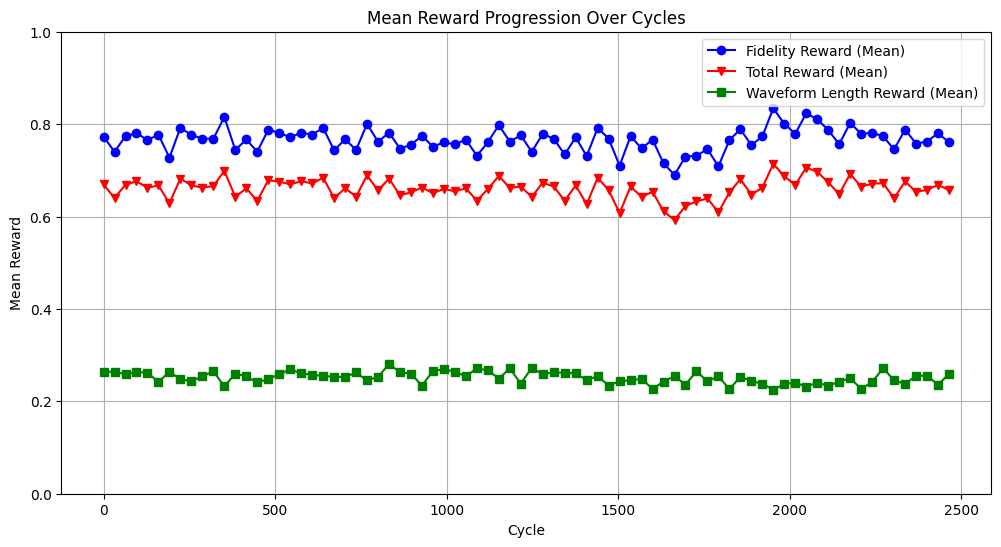

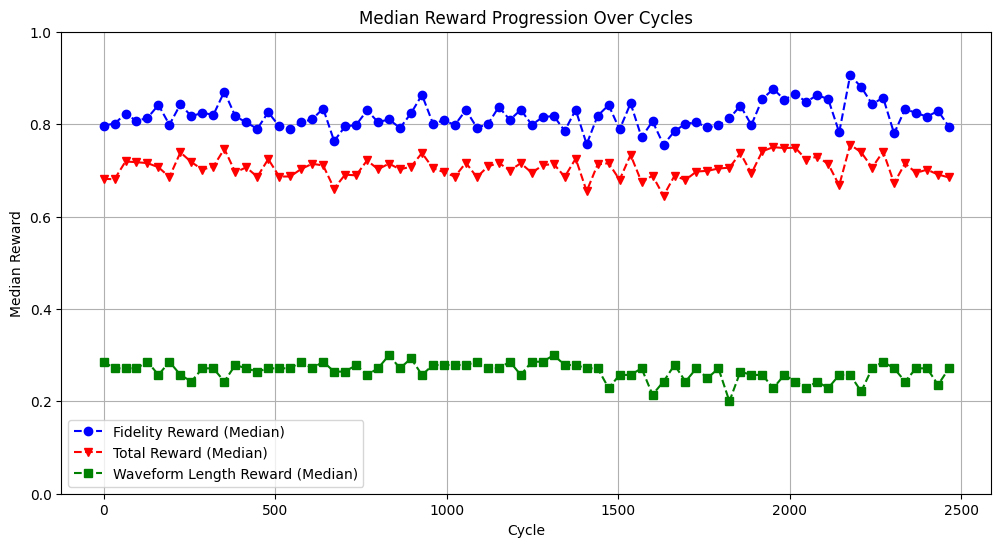

Optimized angles: theta = 3.0902, phi = -1.5610
Optimized fidelity to Rx(pi/2)|0>: 0.9977465849499967


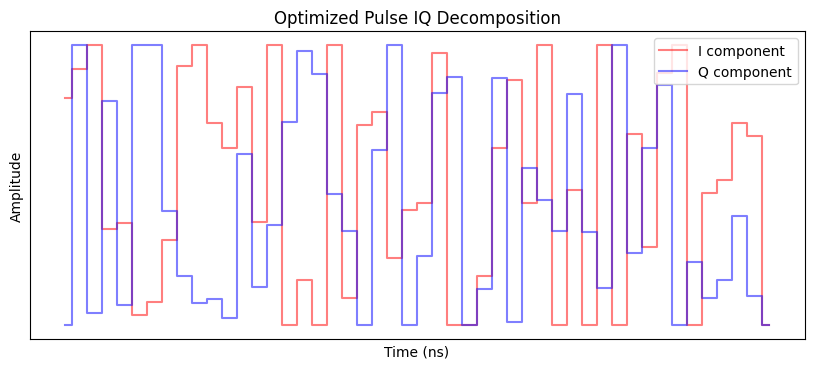

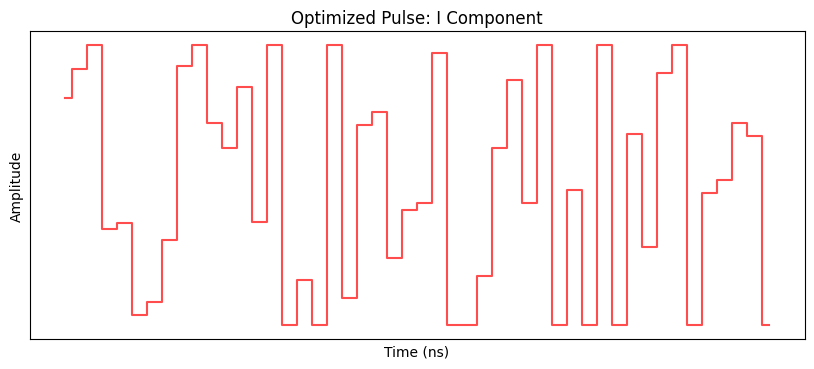

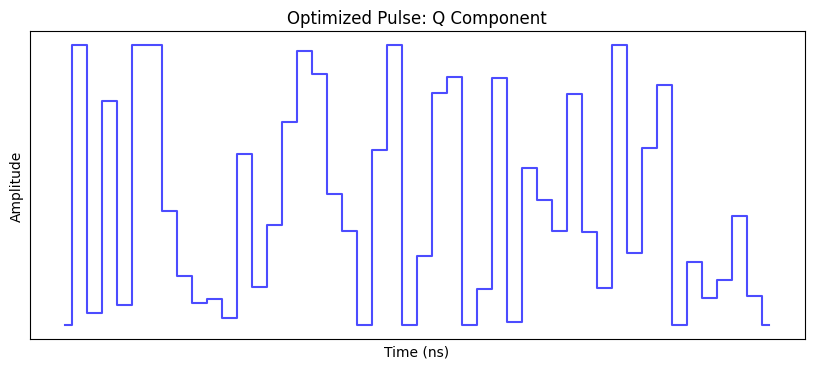

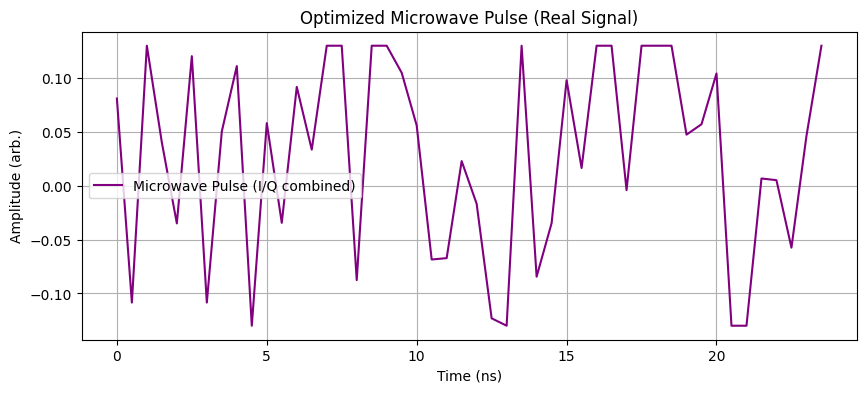

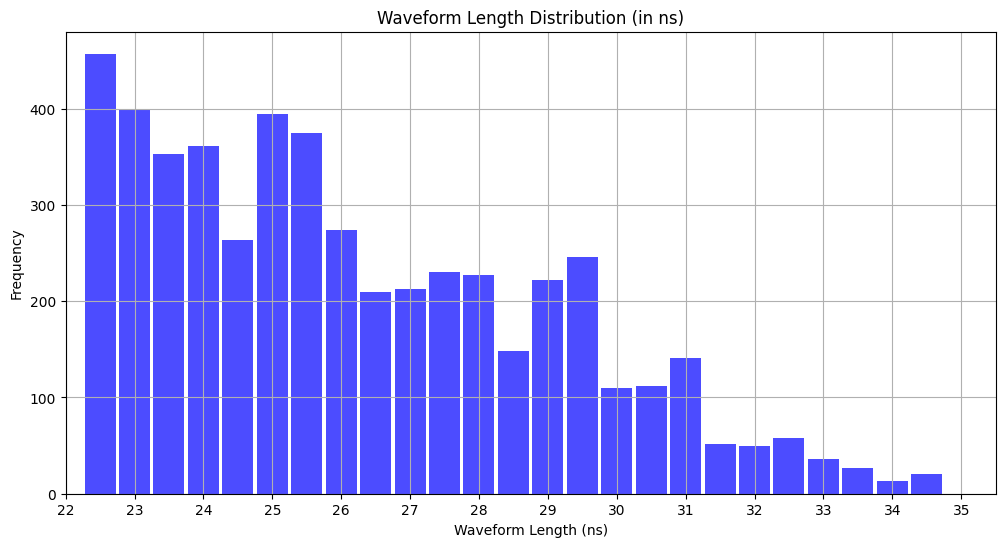

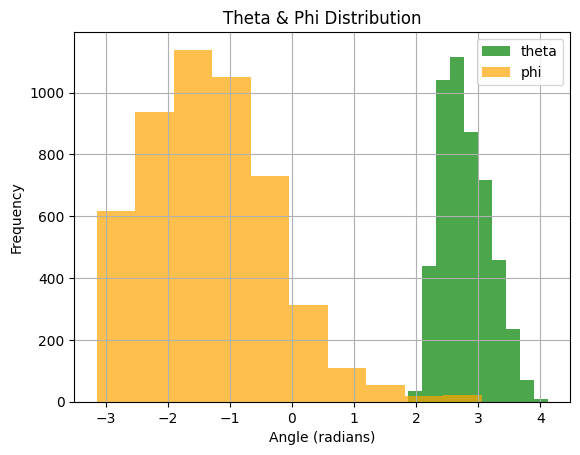

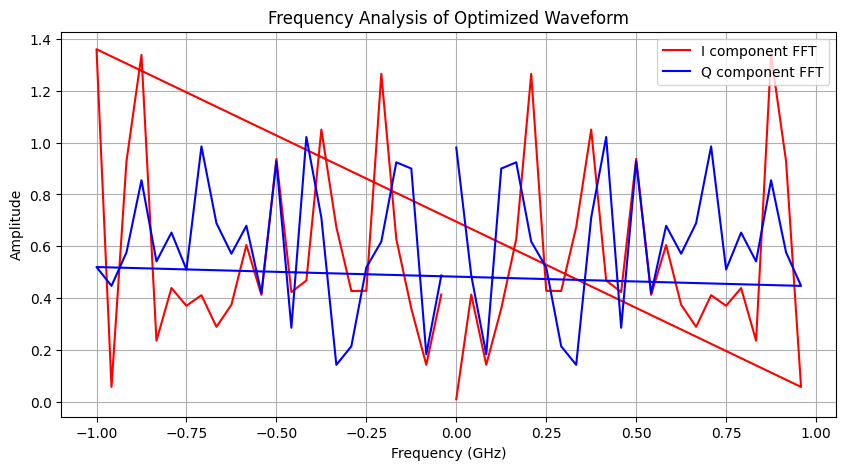

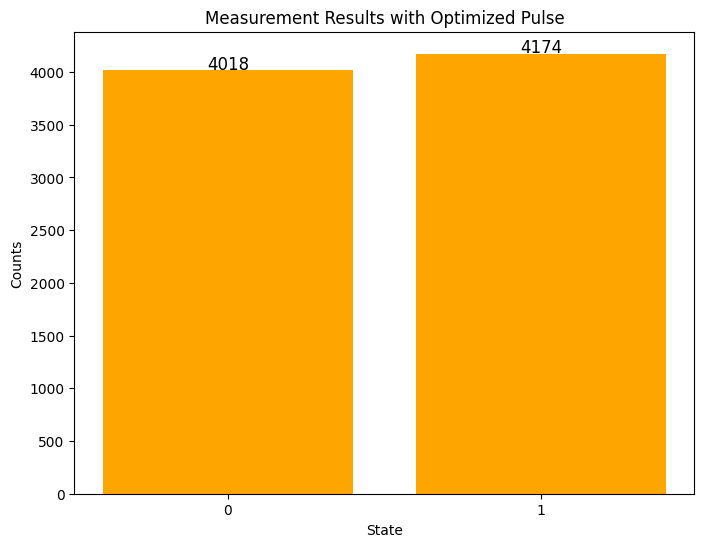

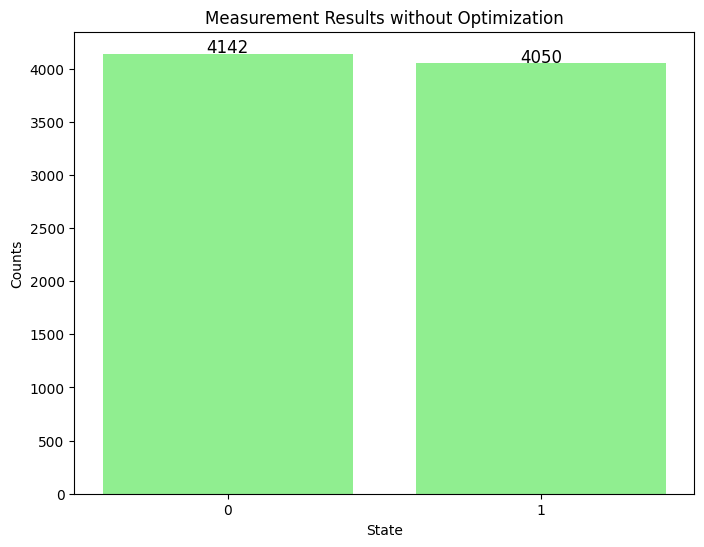

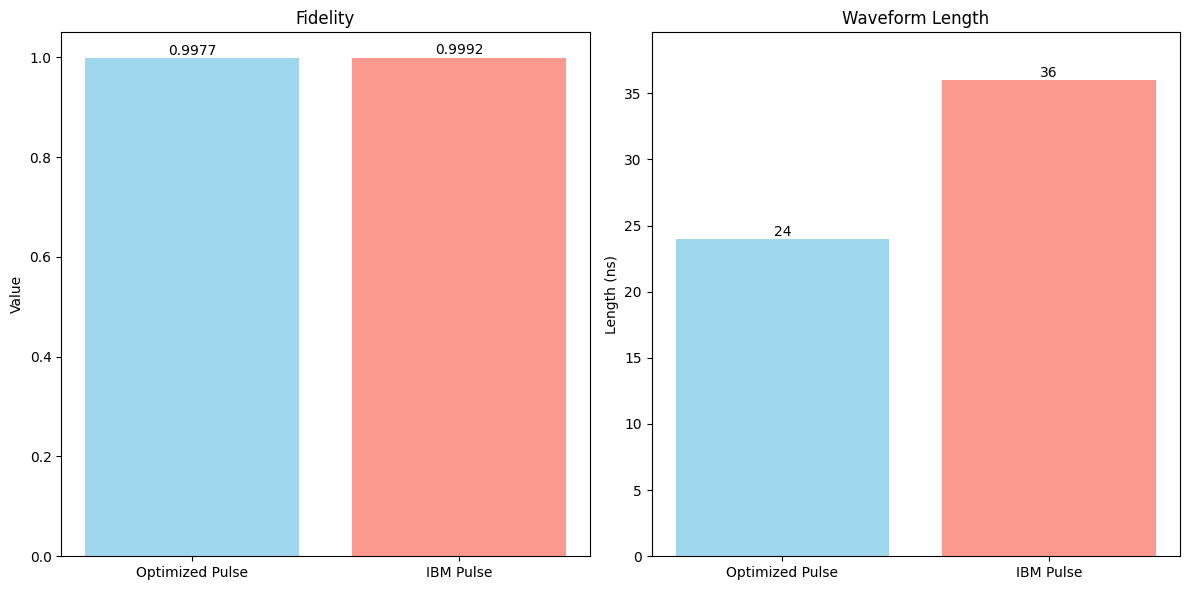

[LOG] saved → /var/folders/c9/jw60jp_d42g04jdjf7qmhj9r0000gn/T/ngrc_cache/run_nav.csv


In [2]:
# nav
for tag in ['nav']:
    RUN_TAG = tag
    use_nav  = True

    # 条件ごとにエージェント再生成（独立性確保）
    agent = MultiObjectivePolicyGradientAgent(
        state_size=8, min_waveform_length=45, max_waveform_length=70,
        initial_learning_rate=0.001
    )

    log_rows = []
    results = design_and_optimize_pulse(
        agent,
        backend_dm=measurement_backend_dm,
        backend_sv=measurement_backend_sv,
        ngrc_model=ng_rc,
        use_nav=True,
        cycles=2500, batch_size=32,
        log_rows=log_rows
    )
    visualize_results(agent, results, batch_size=32, topm=2)
    LOG_PATH = DATA_DIR / f'run_{RUN_TAG}.csv'
    pd.DataFrame(log_rows).to_csv(LOG_PATH, index=False)
    print(f'[LOG] saved → {LOG_PATH}')
